In [1]:
# first, read in the data

import os
import csv

os.chdir('../data/')

records = []

with open('call_records.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        records.append(row)

print(records[0]) # print the header
records = records[1:] # remove the header
print(records[0]) # print an example record

['time', 'cell', 'from', 'to']
['0', '186', '974-703-1399', '876-251-8837']


In [2]:
# Load up the data that was stored from "1. Feature Engineering"
%store -r cph
%store -r num_friends

The first thing we need to do is get this data cleaned up into the format we need - specifically, a list of "feature vectors." These are essentially a list of values (features), each of which describe one data point:

|  | cph | num_friends |
|--|-----|-------------|
|xxx-xxx-xxxx|a|b|
|yyy-yyy-yyyy|x|y|

Note, however, that we don't actually include the numbers in it - we end up with an array like `[[a,b],[x,y],...]` and just need to be sure that we keep it in the same order as `all_numbers` so that we can look up one in the other (e.g. `data[1]` describes `all_numbers[1]`).

In addition to putting the data into the format we need, we also normalize it - that is, scale it all from zero to one. This prevents one feature from overwhelming another - as you recall, we're calculating distance here, so if one feature goes from 0-100 and another from 0-1, points that are at opposite ends of the spectrum 0-1 will seem much closer (to the algorithm) than two points at the opposite ends of 0-100, and therefore the 0-1 scale runs the risk of being basically ignored by the algorithm.

In [3]:
from sklearn import preprocessing
import numpy as np

all_numbers = list(set([r[2] for r in records]))

# build the feature vectors
cph = preprocessing.minmax_scale(cph)
num_friends = preprocessing.minmax_scale(num_friends)
data = [[a, b] for (a, b) in zip(cph, num_friends)]
data = np.array(data)
# normalize it - see:
# https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering
#data = preprocessing.normalize(data)

Let's graph our data just to make sure we didn't break anything.

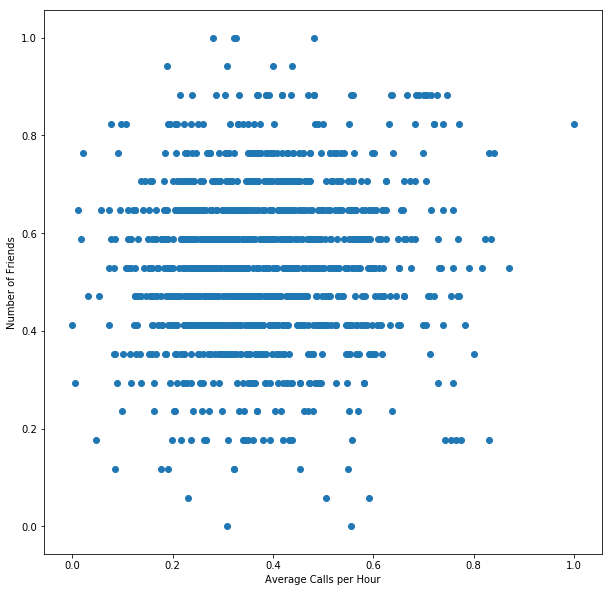

In [4]:
import matplotlib.pyplot as plt # import our graphing module
plt.rcParams["figure.figsize"] = (10,10) # set the default figure size

plt.scatter(*zip(*data))

plt.xlabel('Average Calls per Hour')
plt.ylabel('Number of Friends')
#plt.title('Histogram of Calls per Hour')
plt.show()

And now the actual training and machine learning! It's actually surprisingly simple, once you have the data in the right format.

In [5]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# MeanShift requires a bandwidth parameter - you might want to fiddle with it a little to see what happens,
# but it's perhaps also better to just estimate it with math :)
# for detail, see: http://scikit-learn.org/stable/modules/clustering.html#mean-shift
bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=500)
print(bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = list(set(labels))
n_clusters = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters)


# alternatively, do the clustering with k means
#from sklearn import cluster as clu
#n_clusters = 10
#cluster_output = clu.k_means(data, n_clusters=n_clusters, max_iter=1000)
#labels = cluster_output[1]
#cluster_centers = cluster_output[0]
#print(labels)

# we now have labels, and need to turn that into phone numbers
results = [[] for x in range(n_clusters+1)]
for i,label in enumerate(labels):
    # for each label, grab the number it represents (all_numbers[i]) and
    # put it in the right cluster list (results[label])
    results[label].append(all_numbers[i])
  
for result in results:
    print(result)

0.165035688436
number of estimated clusters : 2
['696-177-8888', '644-124-2329', '362-470-3781', '762-232-5900', '132-440-1834', '896-182-7204', '461-876-8601', '983-278-5144', '560-340-6157', '954-216-8215', '876-308-8025', '640-360-8546', '274-851-9782', '110-212-3018', '549-545-8424', '317-707-5678', '717-362-7073', '761-004-3591', '184-425-3874', '405-555-4139', '543-652-8238', '614-302-3559', '270-547-3421', '603-131-4546', '285-861-4212', '477-146-8041', '978-138-6360', '971-061-9094', '178-485-5232', '534-287-5944', '771-835-1857', '729-704-2749', '434-401-5380', '357-520-9347', '353-156-4985', '434-286-0200', '367-340-4090', '270-188-3408', '717-085-9911', '107-816-8722', '149-758-4038', '725-144-4980', '569-504-0570', '298-411-4528', '789-764-2840', '486-078-1356', '658-046-5987', '332-877-3626', '769-316-3956', '323-720-7329', '962-317-4204', '257-217-5074', '666-661-4262', '552-615-9798', '748-808-5499', '761-638-1151', '427-527-2340', '557-032-2416', '441-736-8868', '709-36

Let's store our results, so we can use them later on (in notebook #4!)

In [6]:
%store all_numbers
%store labels

Stored 'all_numbers' (list)
Stored 'labels' (ndarray)


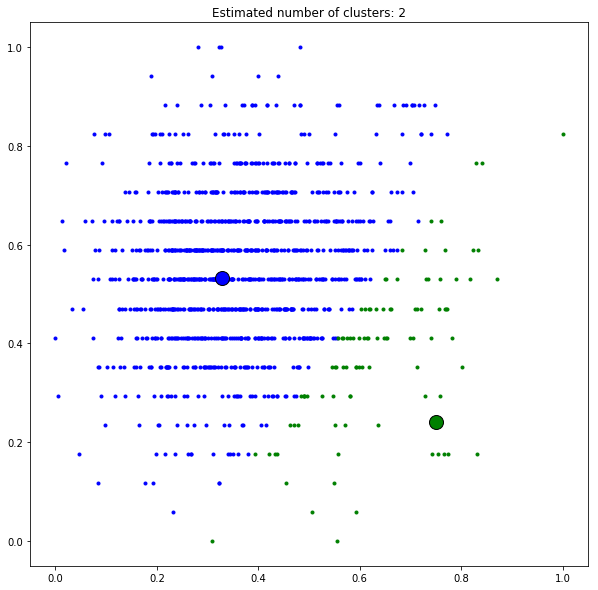

In [7]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(data[my_members, 0], data[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()